# Visualizing the observed distribution

In [ ]:
%pip install -e ..

In [2]:
from pathlib import Path

ROOT = Path.cwd().parent
from pathlib import Path

In [2]:
import xml.etree.ElementTree as ET

FOLDERS = {
    "triads": ROOT / "data" / "compiled" / "triads",
    "strophes": ROOT / "data" / "compiled" / "strophes",
    "epodes": ROOT / "data" / "compiled" / "epodes",
}

def collect_ids(folder: Path) -> set[str]:
    ids: set[str] = set()
    for xml_path in folder.glob("*.xml"):
        try:
            tree = ET.parse(xml_path)
            for elem in tree.iter():
                resp_id = elem.attrib.get("responsion")
                if resp_id:
                    ids.add(resp_id)
        except Exception as exc:
            print(f"Warning: failed to parse {xml_path}: {exc}")
    return ids

def main() -> None:
    results: dict[str, set[str]] = {}
    for name, folder in FOLDERS.items():
        ids = collect_ids(folder)
        results[name] = ids
        print(f"{name}: {len(ids)} unique responsion id values")
        if ids:
            print("IDs:", ", ".join(sorted(ids)))
        print()

    tri, stro, epo = results["triads"], results["strophes"], results["epodes"]
    print("Unique to triads:", ", ".join(sorted(tri - stro - epo)) or "None")
    print("Unique to strophes:", ", ".join(sorted(stro - tri - epo)) or "None")
    print("Unique to epodes:", ", ".join(sorted(epo - tri - stro)) or "None")
    print("\nDone.")

main()

triads: 40 unique responsion id values
IDs: is01, is02, is04, is05, is06, is07, is08, ne01, ne02, ne03, ne04, ne05, ne06, ne07, ne08, ne09, ne10, ne11, ol01, ol02, ol03, ol05, ol06, ol07, ol08, ol09, ol10, ol13, ol14, py01, py02, py03, py04, py05, py06, py08, py09, py10, py11, py12

strophes: 37 unique responsion id values
IDs: is01, is02, is03, is04, is05, is06, ne01, ne03, ne05, ne06, ne07, ne08, ne10, ne11, ol01, ol02, ol03, ol04, ol05, ol06, ol07, ol08, ol09, ol10, ol11, ol12, ol13, py01, py02, py03, py04, py05, py07, py08, py09, py10, py11

epodes: 33 unique responsion id values
IDs: is01, is02, is04, is05, is06, is07, ne01, ne03, ne05, ne06, ne07, ne08, ne10, ne11, ol01, ol02, ol03, ol05, ol06, ol07, ol08, ol09, ol10, ol13, py01, py02, py03, py04, py05, py08, py09, py10, py11

Unique to triads: is08, ne02, ne04, ne09, ol14, py06, py12
Unique to strophes: is03, ol04, ol11, ol12, py07
Unique to epodes: None

Done.


# Test statistics

We define two test statistics. 

The first flattens all normalized compatibility scores across all 11 379 metrical positions, and takes the mean.

Let $T_{pos}$ denote this statistic:

$$ T_{pos} = \frac{1}{11 379} \sum_{pos=1}^{11 379} \bar{x}_{pos}.$$

To avoid longer songs weighing more, we also define a second test statistic that first averages the normalized compatibility scores within each song, and then takes the mean again across the 40 songs. 

Let $T_{song}$ denote this statistic:

$$ T_{song} = \frac{1}{40} \sum_{s=1}^{40} \bar{x}_s.$$

We are going to compute these test statistics for the Pindar corpus, and for 10 000 random baselines, and then perform a one-sided permutation test to see if the observed statistics are significantly higher than the baselines.


## Observed distribution (Pindar)

Let's start with $T_{pos}$ for the Pindar corpus. 

In [15]:
import pickle

from responsio_accentuum import compatibility_corpus, compatibility_canticum, compatibility_ratios_to_stats

corpus_path = ROOT / 'data/compiled/triads'
corpus_path_strophes = ROOT / 'data/compiled/strophes/'
corpus_path_epodes = ROOT / 'data/compiled/epodes/'

corpus_score_pickle_path = ROOT / 'data/cache/all_comp_ratios.pkl'
corpus_score_pickle_path_strophes = ROOT / 'data/cache/all_comp_ratios_strophes.pkl'
corpus_score_pickle_path_epodes = ROOT / 'data/cache/all_comp_ratios_epodes.pkl'

if corpus_score_pickle_path.exists():
    with open(corpus_score_pickle_path, 'rb') as f:
        all_corpus_comp_scores = pickle.load(f)
else:
    print('Calculating all_corpus_comp_scores...')
    all_corpus_comp_scores = compatibility_corpus(corpus_path)
    with open(corpus_score_pickle_path, 'wb') as f:
        pickle.dump(all_corpus_comp_scores, f)

if corpus_score_pickle_path_strophes.exists():
    with open(corpus_score_pickle_path_strophes, 'rb') as f:
        all_corpus_comp_scores_strophes = pickle.load(f)
else:
    print('Calculating all_corpus_comp_scores_strophes...')
    all_corpus_comp_scores_strophes = compatibility_corpus(corpus_path_strophes)
    with open(corpus_score_pickle_path_strophes, 'wb') as f:
        pickle.dump(all_corpus_comp_scores_strophes, f)

if corpus_score_pickle_path_epodes.exists():
    with open(corpus_score_pickle_path_epodes, 'rb') as f:
        all_corpus_comp_scores_epodes = pickle.load(f)
else:
    print('Calculating all_corpus_comp_scores_epodes...')
    all_corpus_comp_scores_epodes = compatibility_corpus(corpus_path_epodes)
    with open(corpus_score_pickle_path_epodes, 'wb') as f:
        pickle.dump(all_corpus_comp_scores_epodes, f)

all_corpus_comp_scores_ba = compatibility_canticum(ROOT / 'data/compiled/extra/ba05.xml', 'ba05')

def count_leaves(obj):
    """Count all leaf (non-list) elements in a nested structure."""
    if isinstance(obj, list):
        return sum(count_leaves(item) for item in obj)
    else:
        return 1

# Calculate T_obs for each category
T_obs_pos_triads = compatibility_ratios_to_stats(all_corpus_comp_scores)
T_obs_triads_ba = compatibility_ratios_to_stats(all_corpus_comp_scores_ba) # For Bacchylides T_pos = T_song

T_obs_pos_strophes = compatibility_ratios_to_stats(all_corpus_comp_scores_strophes)
T_obs_pos_epodes = compatibility_ratios_to_stats(all_corpus_comp_scores_epodes)

# Count total number of variables
total_triads = sum(count_leaves(lst) for lst in all_corpus_comp_scores)
total_triads_ba = sum(count_leaves(lst) for lst in all_corpus_comp_scores_ba)
total_strophes = sum(count_leaves(lst) for lst in all_corpus_comp_scores_strophes)
total_epodes = sum(count_leaves(lst) for lst in all_corpus_comp_scores_epodes)

print ('--------------------------------------------')
print(f'\033[1;33mTRIADS\033[0m\n')
print(f'\033[33mPindar\033[0m: T_pos: \033[1;32m{T_obs_pos_triads:.4f}\033[0m')
print(f'Number of variables: {total_triads}')

print(f'\033[33mBacchylides\033[0m (Ba. 5) T (T_pos = T_song): \033[1;32m{T_obs_triads_ba:.4f}\033[0m')
print(f'Number of variables: {total_triads_ba}')
print ('--------------------------------------------')

print ('\n--------------------------------------------')
print(f'\033[1;33mSTROPHES\033[0m\n')
print(f'\033[33mPindar\033[0m: T_pos: \033[1;32m{T_obs_pos_strophes:.4f}\033[0m')
print(f'Number of variables: {total_strophes}')
print ('--------------------------------------------')

print ('\n--------------------------------------------')
print(f'\033[1;33mEPODES\033[0m\n')
print(f'\033[33mPindar\033[0m: T_pos: \033[1;32m{T_obs_pos_epodes:.4f}\033[0m')
print(f'Number of variables: {total_epodes}')
print ('--------------------------------------------')


--------------------------------------------
TRIADS

Pindar: T_pos: 0.4116
Number of variables: 7361
Bacchylides (Ba. 5) T (T_pos = T_song): 0.3710
Number of variables: 221
--------------------------------------------

--------------------------------------------
STROPHES

Pindar: T_pos: 0.4513
Number of variables: 3543
--------------------------------------------

--------------------------------------------
EPODES

Pindar: T_pos: 0.4077
Number of variables: 1252
--------------------------------------------


Now let's also do $T_{song}$ for all three categories (slightly more work to do here, since we need to average within songs first, and 
- 40 songs respond *simpliciter*,
- only 32 songs are truly triadic, i.e. have responding strophe-antistrophe pairs and epodes),
- 1 song (py07) has only one triad strophe element, hence there is *only* strophic-antistrophic responsion and neither triadic nor epodic responsion 


Overall song-level compatibility scores (T_obs_song):

T_obs_song_triads (40 songs): 0.4154
T_obs_song_strophes (37 songs): 0.4571
T_obs_song_epodes (33 songs): 0.4121

--------------------------------------------
is01
Ode comp: 0.5000 (triads)
Ode comp: 0.4309 (strophes)
Ode comp: 0.5161 (epodes)
--------------------------------------------

--------------------------------------------
is02
Ode comp: 0.4475 (triads)
Ode comp: 0.5090 (strophes)
Ode comp: 0.5070 (epodes)
--------------------------------------------

--------------------------------------------
is03
Ode comp: N/A (triads - not enough strophes)
Ode comp: 0.4326 (strophes)
Ode comp: N/A (epodes - not enough strophe elements)
--------------------------------------------

--------------------------------------------
is04
Ode comp: 0.4075 (triads)
Ode comp: 0.4486 (strophes)
Ode comp: 0.4310 (epodes)
--------------------------------------------

--------------------------------------------
is05
Ode comp: 0.3509 (triads)
Ode 

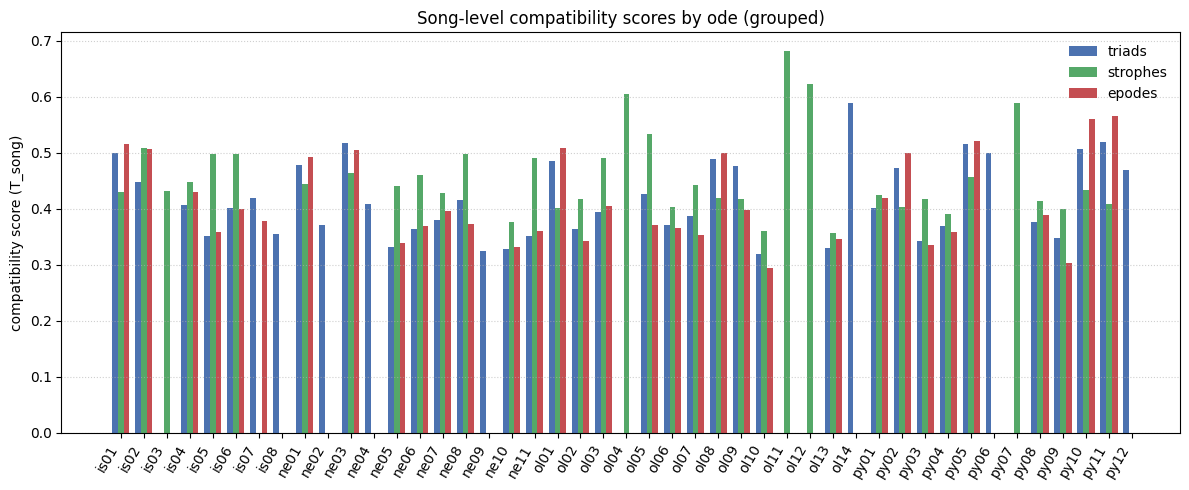

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from responsio_accentuum import compatibility_canticum, compatibility_ratios_to_stats
from responsio_accentuum import victory_odes, victory_odes_not_triadic, canticum_with_at_least_two_strophes

song_scores_triads = {}
song_scores_strophes = {}
song_scores_epodes = {}

responding_unit = ["triads", "strophes", "epodes"]
for unit in responding_unit:
    in_folder_odes = ROOT / f"data/compiled/{unit}/"
    for ode in sorted(set(victory_odes) | set(victory_odes_not_triadic)):
        if ode[:2] == 'py':
            ode_path = in_folder_odes / f"ht_pythians_{unit}.xml"
        elif ode[:2] == 'ne':
            ode_path = in_folder_odes / f"ht_nemeans_{unit}.xml"
        elif ode[:2] == 'ol':
            ode_path = in_folder_odes / f"ht_olympians_{unit}.xml"
        elif ode[:2] == 'is':
            ode_path = in_folder_odes / f"ht_isthmians_{unit}.xml"

        # Check if the canticum exists and has at least 2 strophes
        if not canticum_with_at_least_two_strophes(ode_path, ode):
            continue

        try:
            ode_ratios = compatibility_canticum(ode_path, ode)
            ode_comp = compatibility_ratios_to_stats(ode_ratios)

            if unit == "triads":
                song_scores_triads[ode] = ode_comp
            elif unit == "strophes":
                song_scores_strophes[ode] = ode_comp
            elif unit == "epodes":
                song_scores_epodes[ode] = ode_comp
        except Exception as e:
            print(f"Warning: Could not process {ode} in {unit}: {e}")
            continue

# Calculate T_obs_song
T_obs_song_triads = compatibility_ratios_to_stats(list(song_scores_triads.values()))
T_obs_song_strophes = compatibility_ratios_to_stats(list(song_scores_strophes.values()))
T_obs_song_epodes = compatibility_ratios_to_stats(list(song_scores_epodes.values()))

print("\nOverall song-level compatibility scores (T_obs_song):\n")
print(f"T_obs_song_triads ({len(list(song_scores_triads))} songs): {T_obs_song_triads:.4f}")
print(f"T_obs_song_strophes ({len(list(song_scores_strophes))} songs): {T_obs_song_strophes:.4f}")
print(f"T_obs_song_epodes ({len(list(song_scores_epodes))} songs): {T_obs_song_epodes:.4f}")

all_song_keys = sorted(set(song_scores_triads) | set(song_scores_strophes) | set(song_scores_epodes))

for ode in sorted(all_song_keys):

    print('\n--------------------------------------------')
    print(f'\033[1;32m{ode}\033[0m')
    if ode in song_scores_triads:
        print(f'Ode comp: \033[1;32m{song_scores_triads[ode]:.4f}\033[0m (triads)')
    else:
        print(f'Ode comp: N/A (triads - not enough strophes)')
    
    if ode in song_scores_strophes:
        print(f'Ode comp: \033[1;32m{song_scores_strophes[ode]:.4f}\033[0m (strophes)')
    else:
        print(f'Ode comp: N/A (strophes - not enough strophes)')
    
    if ode in song_scores_epodes:
        print(f'Ode comp: \033[1;32m{song_scores_epodes[ode]:.4f}\033[0m (epodes)')
    else:
        print(f'Ode comp: N/A (epodes - not enough strophe elements)')
    print('--------------------------------------------')

# Histogram-style (grouped bars) of song scores per ode
o_des = sorted(set(victory_odes) | set(song_scores_triads) | set(song_scores_strophes) | set(song_scores_epodes))
x = np.arange(len(o_des))
width = 0.25
triad_vals = np.array([song_scores_triads.get(ode, np.nan) for ode in o_des], dtype=float)
strophes_vals = np.array([song_scores_strophes.get(ode, np.nan) for ode in o_des], dtype=float)
epodes_vals = np.array([song_scores_epodes.get(ode, np.nan) for ode in o_des], dtype=float)

fig, ax = plt.subplots(figsize=(12, 5))
b1 = ax.bar(x - width, triad_vals, width, color='#4c72b0', label='triads')
b2 = ax.bar(x, strophes_vals, width, color='#55a868', label='strophes')
b3 = ax.bar(x + width, epodes_vals, width, color='#c44e52', label='epodes')

ax.set_xticks(x)
ax.set_xticklabels(o_des, rotation=60, ha='right')
ax.set_ylabel('compatibility score (T_song)')
ax.set_title('Song-level compatibility scores by ode (grouped)')
ax.grid(True, axis='y', linestyle=':', alpha=0.6)
ax.legend(frameon=False)
plt.tight_layout()

print(f"\n Score for py07, which has only 1 triad, i.e. 2 strophes: {song_scores_strophes['py07']:.4f}")


## Expected distributions (baselines)

First a test of the prose baseline generator:

In [ ]:
# from responsio_accentuum import one_t_prose

# (T_pos_prose_test, T_song_prose_test) = one_t_prose()

# print("T_pos_prose test:", f"{T_pos_prose_test:.4f}")
# print("T_song_prose test:", f"{T_song_prose_test:.4f}")

And for the lyric! The lyric has more moving parts and needs to be tested separately, since the randomization procedure is different (see `baseline.py` for details).

In [ ]:
# from responsio_accentuum import one_t_lyric

# (T_pos_lyric, T_song_lyric) = one_t_lyric()

# print("T_pos_lyric:", f"{T_pos_lyric:.4f}")
# print("T_song_lyric:", f"{T_song_lyric:.4f}")

T_pos_lyric: 0.3956
T_song_lyric: 0.3947


As expected, *T_pos is slightly lower than T_song* (since longer songs tend to more strictions on responsion) and *the lyric baselines are slightly lower than the prose* (because lyric is also more constrained than prose).

Now let's do the Monte Carlo simulation, i.e. calculate lists of test statstics for n randomizations/permutations of the corpus.

In [5]:
import pickle

from responsio_accentuum import test_statistics

randomizations = 10000
workers = 8
chunk_size = 100
T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list, lyric_stats_summary = test_statistics(
    randomizations,
    workers=workers,
    chunk_size=chunk_size,
    include_lyric_stats=True,
 )

print("\nFirst sample in each test statistic series:\n")
print(f"T_pos_prose_list: \033[1;32m{T_exp_pos_prose_list[0]:.3f}\033[0m")
print(f"T_song_prose_list: \033[1;32m{T_exp_song_prose_list[0]:.3f}\033[0m")
print(f"T_pos_lyric_list: \033[1;32m{T_exp_pos_lyric_list[0]:.3f}\033[0m")
print(f"T_song_lyric_list: \033[1;32m{T_exp_song_lyric_list[0]:.3f}\033[0m")

if lyric_stats_summary:
    print("\nLyric baseline composition (aggregated):")
    for k, v in lyric_stats_summary.items():
        print(f"  {k}: {v}")

pickle_output = ROOT / "data/cache/test_statistics.pkl"
with open(pickle_output, "wb") as f:
    pickle.dump((T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list, lyric_stats_summary), f)

Loaded cached chunk 0_10 (10 iterations)
Loaded cached chunk 10_20 (10 iterations)
Loaded cached chunk 20_30 (10 iterations)
Loaded cached chunk 30_40 (10 iterations)
Loaded cached chunk 40_50 (10 iterations)
Loaded cached chunk 50_60 (10 iterations)
Loaded cached chunk 60_70 (10 iterations)
Loaded cached chunk 70_80 (10 iterations)
Loaded cached chunk 80_90 (10 iterations)
Loaded cached chunk 90_100 (10 iterations)
Loaded cached chunk 100_110 (10 iterations)
Loaded cached chunk 110_120 (10 iterations)
Loaded cached chunk 120_130 (10 iterations)
Loaded cached chunk 130_140 (10 iterations)
Loaded cached chunk 140_150 (10 iterations)
Loaded cached chunk 150_160 (10 iterations)
Loaded cached chunk 160_170 (10 iterations)
Loaded cached chunk 170_180 (10 iterations)
Loaded cached chunk 180_190 (10 iterations)
Loaded cached chunk 190_200 (10 iterations)
Loaded cached chunk 200_210 (10 iterations)
Loaded cached chunk 210_220 (10 iterations)
Loaded cached chunk 220_230 (10 iterations)
Loaded c

In [14]:
import numpy as np
import pickle

pickle_input = ROOT / "data/cache/test_statistics.pkl"

with open(pickle_input, "rb") as f:
    T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list, lyric_stats_summary = pickle.load(f)

# Print mean of each list as .3f list to verify
print("Mean(T_exp_pos_prose_list):", f"{np.mean(T_exp_pos_prose_list):.4f}")
print("Mean(T_exp_song_prose_list):", f"{np.mean(T_exp_song_prose_list):.4f}")
print("Mean(T_exp_pos_lyric_list):", f"{np.mean(T_exp_pos_lyric_list):.4f}")
print("Mean(T_exp_song_lyric_list):", f"{np.mean(T_exp_song_lyric_list):.4f}")

# Compare with T_obs
print("\nComparison with observed T values:")
print(f"T_obs_pos_triads: {T_obs_pos_triads:.4f}")
print(f"T_obs_song_triads: {T_obs_song_triads:.4f}")

if lyric_stats_summary:
    print("\nLyric baseline composition (aggregated):")
    for k, v in lyric_stats_summary.items():
        print(f"  {k}: {v}")

Mean(T_exp_pos_prose_list): 0.3944
Mean(T_exp_song_prose_list): 0.3959
Mean(T_exp_pos_lyric_list): 0.3998
Mean(T_exp_song_lyric_list): 0.4004

Comparison with observed T values:
T_obs_pos_triads: 0.4116
T_obs_song_triads: 0.4154

Lyric baseline composition (aggregated):
  total_lines: 33720000
  pindar_lines: 33720000
  external_lines: 0
  unaltered_lines: 32172932
  trimmed_lines: 1547068
  padded_lines: 0
  paired_fallbacks: 260000


# Significance test

## One-sided permutation test

We perform a one-sided permutation test, because the hypothesis is directional, i.e. we do not expect the test statistic to be symmetric around 0. (A two-sided permutation test has the absolute sizes $|T_{exp, i}| \ge |T_{\text{obs}}|$

Let $T_{\text{obs}} =$ observed statistic (Pindar)
and $\{T_{exp, 1}, \dots, T_{exp, 10000}\} =$ baseline values

Compute, for each list in T_pos_prose_list, T_song_prose_list, T_pos_lyric_list, T_song_lyric_list:

$$p = \frac{1 + \|\{i: T_{exp, i} \ge T_{\text{obs}}\}\|}{1 + 10000}$$

In [7]:
'''
Two observed test statistics: 
T_obs_pos_triads, 
T_obs_song_triads

Four lists of expected test statistics:
T_exp_pos_prose_list, 
T_exp_song_prose_list, 
T_exp_pos_lyric_list,
T_exp_song_lyric_list

T_obs_pos_triads will be compared to entries in T_exp_pos_prose_list and T_exp_pos_lyric_list
T_obs_song_triads will be compared to entries in T_exp_song_prose_list and T_exp_song_lyric_list
'''

import numpy as np

def permutation_p_value(T_obs, baseline):
    baseline_arr = np.asarray(baseline)
    ge_count = np.sum(baseline_arr >= T_obs) # ge = greater than or equal to
    return (1 + ge_count) / (1 + baseline_arr.size) # convention to add 1 to numerator and denominator to avoid zero p-value (source: https://en.wikipedia.org/wiki/P-value#Permutation_tests)


p_pos_prose = permutation_p_value(T_obs_pos_triads, T_exp_pos_prose_list)
p_pos_lyric = permutation_p_value(T_obs_pos_triads, T_exp_pos_lyric_list)

p_song_prose = permutation_p_value(T_obs_song_triads, T_exp_song_prose_list)
p_song_lyric = permutation_p_value(T_obs_song_triads, T_exp_song_lyric_list)

print(f"p_pos_prose (triads vs prose baseline): {p_pos_prose:.4f}")
print(f"p_pos_lyric (triads vs lyric baseline): {p_pos_lyric:.4f}")
print(f"p_song_prose (triads-song vs prose baseline): {p_song_prose:.4f}")
print(f"p_song_lyric (triads-song vs lyric baseline): {p_song_lyric:.4f}")


p_pos_prose (triads vs prose baseline): 0.0030
p_pos_lyric (triads vs lyric baseline): 0.0042
p_song_prose (triads-song vs prose baseline): 0.0014
p_song_lyric (triads-song vs lyric baseline): 0.0009


From more to less significant: 
`p_song_lyric` < `p_song_prose` < `p_pos_prose` < `p_pos_lyric`

All four p-values are below 0.01, which is strong evidence that the observed responsion patterns in Pindar are not due to chance, and that the constraints of lyric and prose do not fully explain the observed patterns.

1. **The song-based statistics are clearly more significant than the position-based statistic**,
    - which suggests that Pindar's shorter songs were more responding.
2. **Testing against lyric is harder (= a better test) than testing against prose**,
    - which is expected.

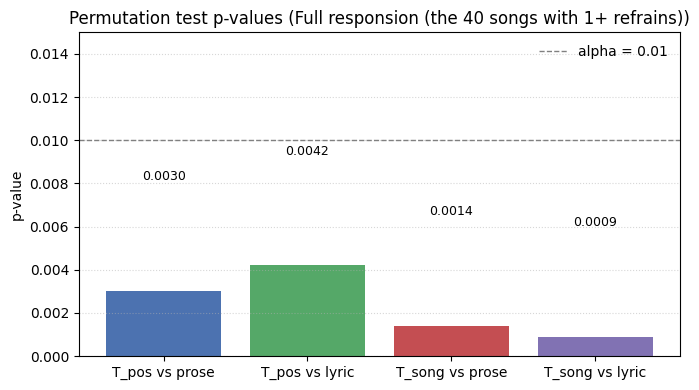

In [10]:
import matplotlib.pyplot as plt

labels = [
    "T_pos vs prose",
    "T_pos vs lyric",
    "T_song vs prose",
    "T_song vs lyric",
]
values = [p_pos_prose, p_pos_lyric, p_song_prose, p_song_lyric]
colors = ["#4c72b0", "#55a868", "#c44e52", "#8172b3"]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(labels, values, color=colors)
#ax.axhline(0.05, color="black", linestyle="--", linewidth=1, label="alpha = 0.05")
ax.axhline(0.01, color="grey", linestyle="--", linewidth=1, label="alpha = 0.01")
ax.set_ylabel("p-value")
ax.set_title("Permutation test p-values (Full responsion (the 40 songs with 1+ refrains))")
ax.set_ylim(0, 0.015)
ax.grid(axis="y", linestyle=":", alpha=0.5)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 0.005, f"{val:.4f}", ha="center", va="bottom", fontsize=9)

ax.legend(frameon=False)
plt.tight_layout()


## Effect size

We can also measure the effect size by computing the z-score of the observed statistic relative to the baseline distribution:

$$z_{\text{emp}} = \frac{T_{\text{obs}} - \mu_0}{\sigma_0}$$

Source: https://en.wikipedia.org/wiki/Permutation_test#One-sided_permutation_test

In [12]:
import numpy as np

def z_score(T_obs, baseline):
    arr = np.asarray(baseline, dtype=float)
    mu = arr.mean()
    sigma = arr.std(ddof=0)
    return (float(T_obs) - mu) / sigma if sigma != 0 else np.nan

z_pos_prose = z_score(T_obs_pos_triads, T_exp_pos_prose_list)
z_pos_lyric = z_score(T_obs_pos_triads, T_exp_pos_lyric_list)

z_song_prose = z_score(T_obs_song_triads, T_exp_song_prose_list)
z_song_lyric = z_score(T_obs_song_triads, T_exp_song_lyric_list)

print(f"z_pos_prose (triads vs prose baseline): {z_pos_prose:.3f}")
print(f"z_pos_lyric (triads vs lyric baseline): {z_pos_lyric:.3f}")
print(f"z_song_prose (triads-song vs prose baseline): {z_song_prose:.3f}")
print(f"z_song_lyric (triads-song vs lyric baseline): {z_song_lyric:.3f}")

z_pos_prose (triads vs prose baseline): 2.646
z_pos_lyric (triads vs lyric baseline): 2.594
z_song_prose (triads-song vs prose baseline): 2.926
z_song_lyric (triads-song vs lyric baseline): 3.111


## Histograms 

It can be interesting to plot the observed distribution and the means of the two baseline distributions as histograms with the bins of normalized compatibility scores. 

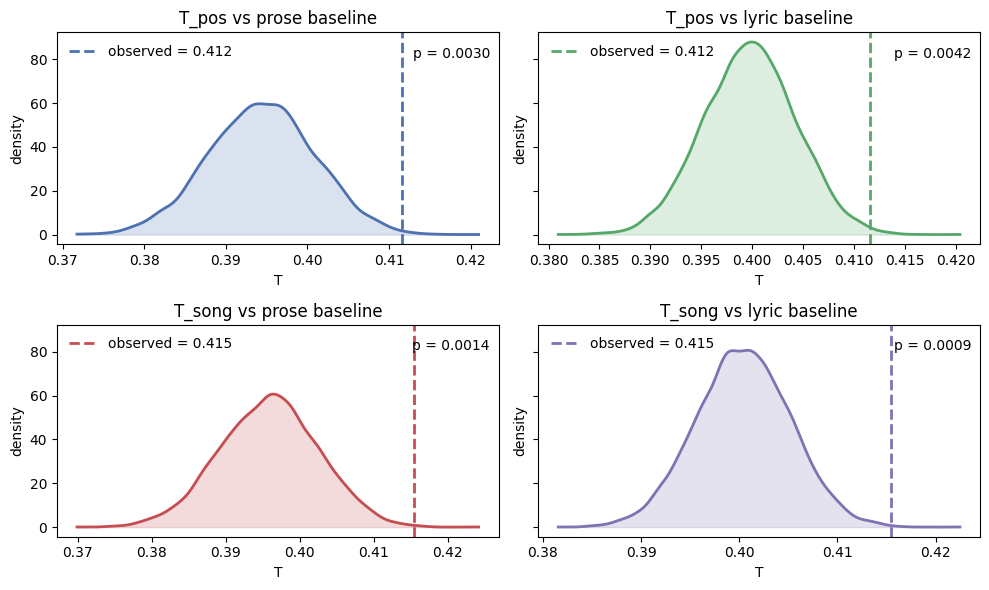

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_baseline_kde(ax, baseline, obs, title, color, pval):
    arr = np.asarray(baseline, dtype=float)
    obs_f = float(obs)
    if arr.std() == 0:
        ax.axvline(arr[0], color=color, linewidth=2, label=f"observed = {obs_f:.3f}")
        ax.set_title(title)
        ax.set_xlabel("T")
        ax.set_ylabel("density")
        ax.legend(frameon=False)
        ax.text(0.98, 0.9, f"p = {pval:.4f}", ha="right", va="center", transform=ax.transAxes)
        return

    kde = gaussian_kde(arr)
    xs = np.linspace(arr.min(), arr.max(), 400)
    ys = kde(xs)
    ax.plot(xs, ys, color=color, linewidth=2)
    ax.fill_between(xs, ys, color=color, alpha=0.2)
    ax.axvline(obs_f, color=color, linestyle="--", linewidth=2, label=f"observed = {obs_f:.3f}")
    ax.set_title(title)
    ax.set_xlabel("T")
    ax.set_ylabel("density")
    ax.legend(frameon=False)
    ax.text(0.98, 0.9, f"p = {pval:.4f}", ha="right", va="center", transform=ax.transAxes)


fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
plot_baseline_kde(axes[0, 0], T_exp_pos_prose_list, T_obs_pos_triads, "T_pos vs prose baseline", "#4c72b0", p_pos_prose)
plot_baseline_kde(axes[0, 1], T_exp_pos_lyric_list, T_obs_pos_triads, "T_pos vs lyric baseline", "#55a868", p_pos_lyric)
plot_baseline_kde(axes[1, 0], T_exp_song_prose_list, T_obs_song_triads, "T_song vs prose baseline", "#c44e52", p_song_prose)
plot_baseline_kde(axes[1, 1], T_exp_song_lyric_list, T_obs_song_triads, "T_song vs lyric baseline", "#8172b3", p_song_lyric)
plt.tight_layout()
plt.savefig(ROOT / "media" / "significance" / "baseline_kde_plots.png", dpi=400)


# Doric experiment

We start by substituting certain Doric forms for their Attic-Alexandrian  equivalents

In [ ]:
from lxml import etree
import os
import re
from pathlib import Path

from grc_utils import normalize_word

def replace_word_in_syllables(search_word: str, replace_word: str, xml_path: Path, output_path: Path) -> bool:
    """
    Replace a word in XML while preserving syllable structure.
    Words are matched with word boundaries (spaces).
    Saves to the specified output_path (required for safety).
    Returns True if replacements were made, False otherwise.
    """
    if output_path is None:
        raise ValueError("output_path is required (specify where to save the modified file)")
    
    with open(xml_path, 'rb') as f:
        tree = etree.parse(f)
    
    root = tree.getroot()
    replacements_made = False
    
    # Normalize search term for matching
    search_word_normalized = normalize_word(search_word)
    
    for l_elem in root.iter('l'):
        # Collect all <syll> elements and their text
        syll_elements = list(l_elem.findall('syll'))
        if not syll_elements:
            continue
        
        # Reconstruct full text with position tracking
        full_text = ''.join(syll.text or '' for syll in syll_elements)
        full_text_normalized = normalize_word(full_text)
        
        # Only replace complete words (with word boundaries)
        pattern = r'\b' + re.escape(search_word_normalized) + r'\b'
        new_text_normalized = re.sub(pattern, normalize_word(replace_word), full_text_normalized)
        
        if new_text_normalized != full_text_normalized:
            replacements_made = True
            # Redistribute the new text across syllables
            char_idx = 0
            for syll in syll_elements:
                old_text = syll.text or ''
                syll_len = len(old_text)
                syll.text = new_text_normalized[char_idx:char_idx + syll_len]
                char_idx += syll_len
    
    if replacements_made:
        with open(output_path, 'wb') as f:
            tree.write(f, encoding='utf-8', xml_declaration=True, pretty_print=True)
    
    return replacements_made

# Process all XML files in the triads directory
triad_path = ROOT / "data/compiled/triads/"
output_doric_triad_path = ROOT / "data/compiled_doric/triads/"

# Ensure output directory exists
output_doric_triad_path.mkdir(parents=True, exist_ok=True)

# Dictionary of Doric/Attic-Alexandrian word substitutions
replacements = {
    "Αἰγιμιοῦ": "Αἰγιμίου",
    "Ἀλφεοῦ": "Ἀλφέου",
    "Δαναοῦ": "Δανάου",
}

triad_files = sorted([triad_path / f for f in os.listdir(triad_path) if f.endswith('.xml')])

print(f"Processing {len(triad_files)} files...")
print(f"Substitutions to perform: {list(replacements.items())}\n")

# Track substitutions per word
substitution_counts = {search: 0 for search in replacements}
total_files_modified = 0

for xml_file in triad_files:
    output_file = output_doric_triad_path / xml_file.name
    file_modified = False
    
    for search_word, replace_word in replacements.items():
        if replace_word_in_syllables(search_word, replace_word, xml_file, output_file):
            substitution_counts[search_word] += 1
            file_modified = True
    
    if file_modified:
        total_files_modified += 1
        print(f"✓ {xml_file.name}: modified")

print(f"\n{'='*60}")
print(f"Summary: {total_files_modified} file(s) modified")
print(f"{'='*60}")
for search_word, count in substitution_counts.items():
    replace_word = replacements[search_word]
    print(f"'{search_word}' → '{replace_word}': {count} substitution(s)")
print(f"{'='*60}")
print(f"Output saved to: {output_doric_triad_path}")


Processing 4 files...
Substitutions to perform: [('Αἰγιμιοῦ', 'Αἰγιμίου'), ('Ἀλφεοῦ', 'Ἀλφέου'), ('Δαναοῦ', 'Δανάου')]

✓ ht_isthmians_triads.xml: modified
✓ ht_nemeans_triads.xml: modified
✓ ht_olympians_triads.xml: modified
✓ ht_pythians_triads.xml: modified

Summary: 4 file(s) modified
'Αἰγιμιοῦ' → 'Αἰγιμίου': 1 substitution(s)
'Ἀλφεοῦ' → 'Ἀλφέου': 3 substitution(s)
'Δαναοῦ' → 'Δανάου': 1 substitution(s)
Output saved to: /Users/albin/git/responsio-accentuum/data/compiled_doric/triads


In [ ]:
from responsio_accentuum import compatibility_corpus, compatibility_canticum, compatibility_ratios_to_stats

output_doric_triad_path = ROOT / "data/compiled_doric/triads/"

# Position-level observed statistic

scores_doric = compatibility_corpus(output_doric_triad_path)
T_obs_pos_triads_doric = compatibility_ratios_to_stats(scores_doric)

# Song-level observed statistic

for collection in scores_doric:
    odes_averages = []
    for ode in collection:
        odes_averages.append(compatibility_ratios_to_stats(ode))

T_obs_song_triads_doric = compatibility_ratios_to_stats(odes_averages)

print(f"\nDoric Triads T_pos: {T_obs_pos_triads_doric:.4f}")
print(f"Doric Triads T_song: {T_obs_song_triads_doric:.4f}")


5it [00:00,  5.48it/s]                       


Doric Triads T_pos: 0.4131
Doric Triads T_song: 0.4214
